In [26]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
import csv
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [27]:
imagePath=r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\data\CarData2"
_cwd = cwd = r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3"
os.chdir(imagePath)
fileNames = glob.glob("*/*.pgm")
target=[]
for fileName in fileNames:
    if fileName.find("neg") > 0:
        target.append(0)
    else:
        target.append(1)
#Delete image *neg-130.pgm because it somehow throws errors during processing
for i in range(0, len(fileNames)):
    if fileNames[i].find('neg-130') > 0:
        toDelete = i
fileNames.pop(toDelete)
target.pop(toDelete)
X_train, X_test, y_train, y_test = train_test_split(fileNames, target, random_state=43)

In [28]:
#sift = cv2.ORB_create()
sift = cv2.xfeatures2d.SIFT_create()
dico = []
for fileName in X_train:
    img = cv2.imread(os.path.join(imagePath, fileName))
    kp, des = sift.detectAndCompute(img, None)
    for d in des:
        dico.append(d)

In [29]:
k = 700
batch_size = 6
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method: k-means++
Inertia for init 1/3: 182343.500000
Init 2/3 with method: k-means++
Inertia for init 2/3: 0.000000
Init 3/3 with method: k-means++
Inertia for init 3/3: 0.000000
Minibatch iteration 1/2137200: mean batch inertia: 119252.333333, ewa inertia: 119252.333333 
Minibatch iteration 2/2137200: mean batch inertia: 89123.166667, ewa inertia: 119249.513812 
Minibatch iteration 3/2137200: mean batch inertia: 83942.000000, ewa inertia: 119246.209696 
Minibatch iteration 4/2137200: mean batch inertia: 100840.333333, ewa inertia: 119244.487253 
Minibatch iteration 5/2137200: mean batch inertia: 127674.666667, ewa inertia: 119245.276159 
Minibatch iteration 6/2137200: mean batch inertia: 107365.333333, ewa inertia: 119244.164421 
Minibatch iteration 7/2137200: mean batch inertia: 128343.333333, ewa inertia: 119245.015931 
Minibatch iteration 8/2137200: mean batch inertia: 100093.000000, ewa inertia: 119243.223664 
Minibatch iteration 9/2137200: mean batch inertia: 12093

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=18 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=18 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=18 should be larger than k=700. Setting it to 3*k
  init_size=init_size)


In [30]:
kmeans.verbose = False
histo_list = []
for fileName in X_train:
    img = cv2.imread(os.path.join(imagePath, fileName))
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefer to add 1/nkp directly
    histo_list.append(histo)    

In [31]:
X = np.array(histo_list)

#mlp = MLPClassifier(verbose=True, max_iter=600)
#mlp.fit(X, y_train)
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
predictions = []
xes_test = []
for fileName in X_test:
    img = cv2.imread(os.path.join(imagePath, fileName))
    kp, des = sift.detectAndCompute(img, None)
    x = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp
    #res = clf.predict_proba([x])
    predictions.append(clf.predict([x]))
    xes_test.append(x)
    

In [33]:
XX = X.copy()
XX = np.concatenate((XX, np.array(xes_test)))
YY = np.concatenate((y_train, y_test))

In [34]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
rfclf_param_grid = {
  "n_estimators": [100, 300],
  "max_depth": [5, 7, None],
  "max_features": [5, "auto"],
  }
rfclf = RandomForestClassifier()
rfclf_grid_search = GridSearchCV(rfclf, param_grid=rfclf_param_grid, cv=10, n_jobs=1)
rfclf_grid_search.fit(XX, YY)
report(rfclf_grid_search.cv_results_) 

Model with rank: 1
Mean validation score: 0.938 (std: 0.020)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.937 (std: 0.016)
Parameters: {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.934 (std: 0.021)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}



In [35]:
mlpclf_param_grid = {"hidden_layer_sizes": [(30,), (100,), (100,30)], #, (30, 30, 20), smaller ones e.g. 10; 15; 15,15 worse
              "activation": [ "relu"], #tanh worse
              "solver": ["adam"], #lbfgs worse
              "alpha": [0.0001, 0.001], #0.0001, 0.005, 
              "max_iter": [200, 500]} # 100, 200 worse, does not converge
mlpclf = MLPClassifier()
mlpclf_grid_search = GridSearchCV(mlpclf, param_grid=mlpclf_param_grid, cv=10, n_jobs=1)
mlpclf_grid_search.fit(XX, YY)
report(mlpclf_grid_search.cv_results_) 

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_net

Model with rank: 1
Mean validation score: 0.843 (std: 0.018)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30,), 'max_iter': 200, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.838 (std: 0.017)
Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (30,), 'max_iter': 200, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.831 (std: 0.028)
Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}



In [36]:
classifiers = [("Kneighbors", KNeighborsClassifier()),
               ('GaussianNB', GaussianNB()), 
               ('RandomForest', RandomForestClassifier()),
               ('RandomForest_OPT', RandomForestClassifier(n_estimators=300)),
               ('SVC', SVC()),
               ('MLP', MLPClassifier()),
               ('MLP_OPT', MLPClassifier(alpha=0.0001, hidden_layer_sizes=(30,), max_iter=200))
              ]
arr = []
for classifier_tuple in classifiers:
    print(classifier_tuple[0]) 
    scores = cross_val_score(classifier_tuple[1], XX, YY, cv=10)
    #print(cross_val_score(classifier, train, target, cv=3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    arr.append(scores.mean())
    
    Xp_train, Xp_test, yp_train, yp_test =  train_test_split(XX, YY, random_state=42)
    classifier_tuple[1].fit(Xp_train, yp_train)
    yp_pred = classifier_tuple[1].predict(Xp_test)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
    plt.rcParams.update({'font.size': 13})
    cm = confusion_matrix(yp_test, yp_pred)
    df_cm = pd.DataFrame(cm, index=["negative", "positive"], columns=["negative", "positive"])
    g = sns.heatmap(df_cm, annot=True,ax=ax)
    a = plt.title('Confusion Matrix of ' + classifier_tuple[0] + ' (Accuracy: ' + "{:.2f}".format(scores.mean()) + ')')
    g.get_figure().savefig(os.path.join(_cwd,'plots','cm_car_sift_' + classifier_tuple[0] + "_{:.0f}".format(scores.mean()*100)+'.png'))
    plt.close()

Kneighbors
Accuracy: 0.63 (+/- 0.00)
GaussianNB
Accuracy: 0.88 (+/- 0.07)
RandomForest
Accuracy: 0.90 (+/- 0.05)
RandomForest_OPT
Accuracy: 0.94 (+/- 0.04)
SVC
Accuracy: 0.62 (+/- 0.00)
MLP
Accuracy: 0.83 (+/- 0.05)
MLP_OPT
Accuracy: 0.84 (+/- 0.03)


c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators wil

In [37]:
classifier_names = [clf_tuple[0] for clf_tuple in classifiers]
df = pd.DataFrame(data=arr,columns=['accuracy'])
df['classifier'] = classifier_names

Text(0.5, 1.0, 'Performance by classifier')

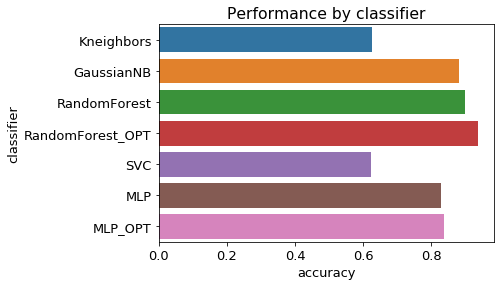

In [38]:
sns.barplot(x="accuracy", y="classifier", data=df)
plt.title('Performance by classifier')